In [197]:
import pandas as pan
pan.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Pre-processing

### Joining data

In [ ]:
raw_tx_features = pan.read_csv('tx_features_extract.csv')
raw_tx_in_features = pan.read_csv('tx_in_features.csv')
raw_tx_out_features = pan.read_csv('tx_out_features.csv')
address_labels = pan.read_csv('address-labels.csv')

In [34]:
merged_tx_in_tx_out = pan.merge(left= raw_tx_out_features, right= raw_tx_in_features, how="inner", on="address")
merged_tx_in_tx_out_tx = pan.merge(left= merged_tx_in_tx_out, right= raw_tx_features, how="inner", on="address")
raw_features = pan.merge(left= merged_tx_in_tx_out_tx, right= address_labels, how="inner", on="address")

### Preprocessing after join

In [198]:
raw_features = pan.read_csv('raw_features.csv')
raw_features

,address,address_out_count,sum_spent,max_spent,min_spent,avg_spent,max_index,min_index,avg_index,address_in_count,...,tx_size_max,tx_size_min,tx_num_of_inp_avg,tx_num_of_inp_max,tx_num_of_inp_min,tx_num_of_out_avg,tx_num_of_out_max,tx_num_of_out_min,SW,label
0,1129kyeRZLvvyt9wKXfszprCme5vUxPGEU,1,187029,187029,187029,187029.0,2,2,2.0,1,...,44296,44296,300.0,300,300,1.0,1,1,SA,Gambling
1,112agXBu72qPgYErvqqEqgRropHacJfH2p,1,20000000,20000000,20000000,20000000.0,0,0,0.0,1,...,14792,14792,100.0,100,100,1.0,1,1,SA,Gambling
2,112MpvBrfpEm6AQoUEZ6X5rGJDjCMWMzdU,1,120220,120220,120220,120220.0,0,0,0.0,1,...,21157,21157,132.0,132,132,2.0,2,2,SA,Cyber-Security Service
3,112THsEt2X7ih88ozzk9AraDCdyLT1Y7hT,1,784175,784175,784175,784175.0,1,1,1.0,1,...,44277,44277,300.0,300,300,1.0,1,1,SA,Gambling
4,1138ue28jT9N8dVn3SXLuBc9jCEPziCGF9,1,35543,35543,35543,35543.0,43,43,43.0,1,...,7561,7561,51.0,51,51,1.0,1,1,SA,Cyber-Security Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57195,bc1qyh4rgftkll4gc7nz9wd2qvtqnpftrs7dxhzvex,1,233874369,233874369,233874369,233874369.0,183,183,183.0,1,...,13292,13292,2.0,2,2,395.0,395,395,SA,Mining Pool
57196,bc1qykuelp5454e78rf7e70q8qhtu5f5tm6sts066k,1,1444984,1444984,1444984,1444984.0,0,0,0.0,1,...,13695,13695,3.0,3,3,402.0,402,402,SA,Mining Pool
57197,bc1qyv35fd7zz59mcdv9npan630mjnv4qlsqfhfhcz,1,4121098,4121098,4121098,4121098.0,0,0,0.0,1,...,735,735,4.0,4,4,2.0,2,2,SA,Cyber-Security Service
57198,bc1qz9em0y32zaywfjrsg4ze244fww9fhxh2c9crak,1,7578363,7578363,7578363,7578363.0,0,0,0.0,1,...,908,908,5.0,5,5,2.0,2,2,SA,Cyber-Security Service


## Removing unnecessary features

In [199]:
raw_features = raw_features.drop(['max_index', 'min_index', 'avg_index'], axis=1)
raw_features

,address,address_out_count,sum_spent,max_spent,min_spent,avg_spent,address_in_count,sum_granted,max_granted,min_granted,...,tx_size_max,tx_size_min,tx_num_of_inp_avg,tx_num_of_inp_max,tx_num_of_inp_min,tx_num_of_out_avg,tx_num_of_out_max,tx_num_of_out_min,SW,label
0,1129kyeRZLvvyt9wKXfszprCme5vUxPGEU,1,187029,187029,187029,187029.0,1,187029,187029,187029,...,44296,44296,300.0,300,300,1.0,1,1,SA,Gambling
1,112agXBu72qPgYErvqqEqgRropHacJfH2p,1,20000000,20000000,20000000,20000000.0,1,20000000,20000000,20000000,...,14792,14792,100.0,100,100,1.0,1,1,SA,Gambling
2,112MpvBrfpEm6AQoUEZ6X5rGJDjCMWMzdU,1,120220,120220,120220,120220.0,1,120220,120220,120220,...,21157,21157,132.0,132,132,2.0,2,2,SA,Cyber-Security Service
3,112THsEt2X7ih88ozzk9AraDCdyLT1Y7hT,1,784175,784175,784175,784175.0,1,784175,784175,784175,...,44277,44277,300.0,300,300,1.0,1,1,SA,Gambling
4,1138ue28jT9N8dVn3SXLuBc9jCEPziCGF9,1,35543,35543,35543,35543.0,1,35543,35543,35543,...,7561,7561,51.0,51,51,1.0,1,1,SA,Cyber-Security Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57195,bc1qyh4rgftkll4gc7nz9wd2qvtqnpftrs7dxhzvex,1,233874369,233874369,233874369,233874369.0,1,233874369,233874369,233874369,...,13292,13292,2.0,2,2,395.0,395,395,SA,Mining Pool
57196,bc1qykuelp5454e78rf7e70q8qhtu5f5tm6sts066k,1,1444984,1444984,1444984,1444984.0,1,1444984,1444984,1444984,...,13695,13695,3.0,3,3,402.0,402,402,SA,Mining Pool
57197,bc1qyv35fd7zz59mcdv9npan630mjnv4qlsqfhfhcz,1,4121098,4121098,4121098,4121098.0,1,4121098,4121098,4121098,...,735,735,4.0,4,4,2.0,2,2,SA,Cyber-Security Service
57198,bc1qz9em0y32zaywfjrsg4ze244fww9fhxh2c9crak,1,7578363,7578363,7578363,7578363.0,1,7578363,7578363,7578363,...,908,908,5.0,5,5,2.0,2,2,SA,Cyber-Security Service


## Adding Balance feature

In [200]:
raw_features['balance'] = raw_features['sum_spent'] - raw_features['sum_granted']
raw_features

,address,address_out_count,sum_spent,max_spent,min_spent,avg_spent,address_in_count,sum_granted,max_granted,min_granted,...,tx_size_min,tx_num_of_inp_avg,tx_num_of_inp_max,tx_num_of_inp_min,tx_num_of_out_avg,tx_num_of_out_max,tx_num_of_out_min,SW,label,balance
0,1129kyeRZLvvyt9wKXfszprCme5vUxPGEU,1,187029,187029,187029,187029.0,1,187029,187029,187029,...,44296,300.0,300,300,1.0,1,1,SA,Gambling,0
1,112agXBu72qPgYErvqqEqgRropHacJfH2p,1,20000000,20000000,20000000,20000000.0,1,20000000,20000000,20000000,...,14792,100.0,100,100,1.0,1,1,SA,Gambling,0
2,112MpvBrfpEm6AQoUEZ6X5rGJDjCMWMzdU,1,120220,120220,120220,120220.0,1,120220,120220,120220,...,21157,132.0,132,132,2.0,2,2,SA,Cyber-Security Service,0
3,112THsEt2X7ih88ozzk9AraDCdyLT1Y7hT,1,784175,784175,784175,784175.0,1,784175,784175,784175,...,44277,300.0,300,300,1.0,1,1,SA,Gambling,0
4,1138ue28jT9N8dVn3SXLuBc9jCEPziCGF9,1,35543,35543,35543,35543.0,1,35543,35543,35543,...,7561,51.0,51,51,1.0,1,1,SA,Cyber-Security Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57195,bc1qyh4rgftkll4gc7nz9wd2qvtqnpftrs7dxhzvex,1,233874369,233874369,233874369,233874369.0,1,233874369,233874369,233874369,...,13292,2.0,2,2,395.0,395,395,SA,Mining Pool,0
57196,bc1qykuelp5454e78rf7e70q8qhtu5f5tm6sts066k,1,1444984,1444984,1444984,1444984.0,1,1444984,1444984,1444984,...,13695,3.0,3,3,402.0,402,402,SA,Mining Pool,0
57197,bc1qyv35fd7zz59mcdv9npan630mjnv4qlsqfhfhcz,1,4121098,4121098,4121098,4121098.0,1,4121098,4121098,4121098,...,735,4.0,4,4,2.0,2,2,SA,Cyber-Security Service,0
57198,bc1qz9em0y32zaywfjrsg4ze244fww9fhxh2c9crak,1,7578363,7578363,7578363,7578363.0,1,7578363,7578363,7578363,...,908,5.0,5,5,2.0,2,2,SA,Cyber-Security Service,0


## Potential Features

### Standard deviations
### Transaction rate(Time between two transactions)

## Adding new features

### difference between outputs and inputs counts

In [201]:
raw_features['diff_in_out_count'] = raw_features['address_out_count'] - raw_features['address_in_count']

### ratio of outputs and input counts/values

In [202]:
raw_features['ratio_in_out_count'] = raw_features['address_in_count'] / raw_features['address_out_count']
raw_features['ratio_in_out_values'] = raw_features['sum_granted'] / raw_features['sum_spent']

### Input/output Min/Max difference

In [203]:
raw_features['range_spent'] = raw_features['max_spent'] - raw_features['min_spent']
raw_features['range_granted'] = raw_features['max_granted'] - raw_features['min_granted']

### Input/Output Range to Sum Ratio

In [204]:
raw_features['ratio_range_to_value_output'] = raw_features.range_spent / raw_features.sum_spent 
raw_features['ratio_range_to_value_input'] = raw_features.range_granted / raw_features.sum_granted

### Input/Output Index Range

In [205]:
raw_features['range_output_index'] = raw_features['max_output_index'] - raw_features['min_output_index']
raw_features['range_input_index'] = raw_features['max_input_index'] - raw_features['min_input_index']

### Life Period

In [206]:
raw_features['life_period'] = raw_features['first_time_tx'] - raw_features['last_time_tx']

### Transaction-based Range

In [207]:
raw_features['range_tx_size'] = raw_features['tx_size_max'] - raw_features['tx_size_min']
raw_features['range_tx_num_of_out'] = raw_features['tx_num_of_out_max'] - raw_features['tx_num_of_out_min']
raw_features['range_tx_num_of_inp'] = raw_features['tx_num_of_inp_max'] - raw_features['tx_num_of_inp_min']

In [208]:
raw_features = raw_features.reset_index()
raw_features = raw_features.drop('index', axis=1)

### Reorder columns

In [209]:
cols = list(raw_features.columns)
sw_index = cols.index('SW')
label_index = cols.index('label')
range_inp_index = cols.index('range_tx_num_of_inp')
range_out_index = cols.index('range_tx_num_of_out')
cols[sw_index], cols[range_out_index] = cols[range_out_index], cols[sw_index]
cols[label_index], cols[range_inp_index] = cols[range_inp_index], cols[label_index]
raw_features = raw_features[cols]

### making dataset for strongly addressed labels

In [214]:
strongly_addressed_features = raw_features.loc[raw_features['SW'] == 'SA']

In [215]:
strongly_addressed_features.label.value_counts()

Centralized Exchange                    31252
Gambling                                10729
Cyber-Security Service                  10581
Tumbler                                  1414
Darknet Market                           1226
P2P Financial Service                     924
Mining Pool                               114
P2P Financial Infrastructure Service       29
Individual Wallet                           4
Government Criminal Blacklist               2
Ponzi Scheme                                2
Name: label, dtype: int64

In [216]:
strongly_addressed_features = strongly_addressed_features.loc[
    (strongly_addressed_features['label'] != 'Government Criminal Blacklist') & 
    (strongly_addressed_features['label'] != 'Ponzi Scheme') &
    (strongly_addressed_features['label'] != 'Individual Wallet')]
strongly_addressed_features = strongly_addressed_features.reset_index()
strongly_addressed_features = strongly_addressed_features.drop(['SW', 'index'], axis=1)

### removing unbalanced labels

In [141]:
raw_features.label.value_counts()

Centralized Exchange                    31252
Gambling                                10729
Cyber-Security Service                  10581
Tumbler                                  1548
Darknet Market                           1226
P2P Financial Service                     924
Blackmail                                 643
Individual Wallet                         150
Mining Pool                               114
P2P Financial Infrastructure Service       29
Government Criminal Blacklist               2
Ponzi Scheme                                2
Name: label, dtype: int64

In [142]:
raw_features = raw_features.loc[(raw_features['label'] != 'Government Criminal Blacklist') & (raw_features['label'] != 'Ponzi Scheme')]

In [144]:
raw_features = raw_features.reset_index()
raw_features = raw_features.drop(['SW', 'index'], axis=1)

,address,address_out_count,sum_spent,max_spent,min_spent,avg_spent,address_in_count,sum_granted,max_granted,min_granted,...,ratio_in_out_values,range_spent,range_granted,ratio_range_to_value_output,ratio_range_to_value_input,range_output_index,range_input_index,life_period,range_tx_size,label
0,1129kyeRZLvvyt9wKXfszprCme5vUxPGEU,1,187029,187029,187029,187029.0,1,187029,187029,187029,...,1.0,0,0,0.0,0.0,0,0,0,0,Gambling
1,112agXBu72qPgYErvqqEqgRropHacJfH2p,1,20000000,20000000,20000000,20000000.0,1,20000000,20000000,20000000,...,1.0,0,0,0.0,0.0,0,0,0,0,Gambling
2,112MpvBrfpEm6AQoUEZ6X5rGJDjCMWMzdU,1,120220,120220,120220,120220.0,1,120220,120220,120220,...,1.0,0,0,0.0,0.0,0,0,0,0,Cyber-Security Service
3,112THsEt2X7ih88ozzk9AraDCdyLT1Y7hT,1,784175,784175,784175,784175.0,1,784175,784175,784175,...,1.0,0,0,0.0,0.0,0,0,0,0,Gambling
4,1138ue28jT9N8dVn3SXLuBc9jCEPziCGF9,1,35543,35543,35543,35543.0,1,35543,35543,35543,...,1.0,0,0,0.0,0.0,0,0,0,0,Cyber-Security Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57191,bc1qyh4rgftkll4gc7nz9wd2qvtqnpftrs7dxhzvex,1,233874369,233874369,233874369,233874369.0,1,233874369,233874369,233874369,...,1.0,0,0,0.0,0.0,0,0,0,0,Mining Pool
57192,bc1qykuelp5454e78rf7e70q8qhtu5f5tm6sts066k,1,1444984,1444984,1444984,1444984.0,1,1444984,1444984,1444984,...,1.0,0,0,0.0,0.0,0,0,0,0,Mining Pool
57193,bc1qyv35fd7zz59mcdv9npan630mjnv4qlsqfhfhcz,1,4121098,4121098,4121098,4121098.0,1,4121098,4121098,4121098,...,1.0,0,0,0.0,0.0,0,0,0,0,Cyber-Security Service
57194,bc1qz9em0y32zaywfjrsg4ze244fww9fhxh2c9crak,1,7578363,7578363,7578363,7578363.0,1,7578363,7578363,7578363,...,1.0,0,0,0.0,0.0,0,0,0,0,Cyber-Security Service


In [155]:
raw_features.label.value_counts()

Centralized Exchange                    31252
Gambling                                10729
Cyber-Security Service                  10581
Tumbler                                  1548
Darknet Market                           1226
P2P Financial Service                     924
Blackmail                                 643
Individual Wallet                         150
Mining Pool                               114
P2P Financial Infrastructure Service       29
Name: label, dtype: int64

## Training Phase

In [240]:
train_test_data = pan.read_csv('prepared-features.csv')

In [241]:
train_test_features = train_test_data.drop(['address', 'label'], axis=1)
train_test_labels = train_test_data['label']

In [242]:
train_features, test_features, train_labels, test_labels = train_test_split(train_test_features, 
                            train_test_labels, train_size=0.6, random_state=111, stratify=train_test_labels)

### On Weak+strongly labeled data

#### Using Decision tree classifier

In [264]:
clf = DecisionTreeClassifier(random_state=None)
cross_val_score(clf, train_features, train_labels, cv=8)

array([0.95594406, 0.96223776, 0.96433566, 0.95477855, 0.95757576,
       0.9568664 , 0.95709956, 0.95989741])

In [265]:
clf.fit(train_features, train_labels)
predicted_labels = clf.predict(test_features)

In [266]:
accuracy_score(test_labels, predicted_labels)

0.9621486953101097

In [267]:
f1_score(test_labels, predicted_labels, average=None)

array([0.46732673, 0.98899604, 0.94667451, 0.89361702, 0.97226107,
       0.112     , 0.97777778, 0.57142857, 0.93296854, 0.82076237])

In [268]:
recall_score(test_labels, predicted_labels, average=None)

array([0.45914397, 0.98856092, 0.95014178, 0.9       , 0.97180801,
       0.11666667, 0.95652174, 0.5       , 0.92162162, 0.8174475 ])

In [269]:
precision_score(test_labels, predicted_labels, average=None)

array([0.47580645, 0.98943155, 0.94323247, 0.88732394, 0.97271455,
       0.10769231, 1.        , 0.66666667, 0.94459834, 0.82410423])

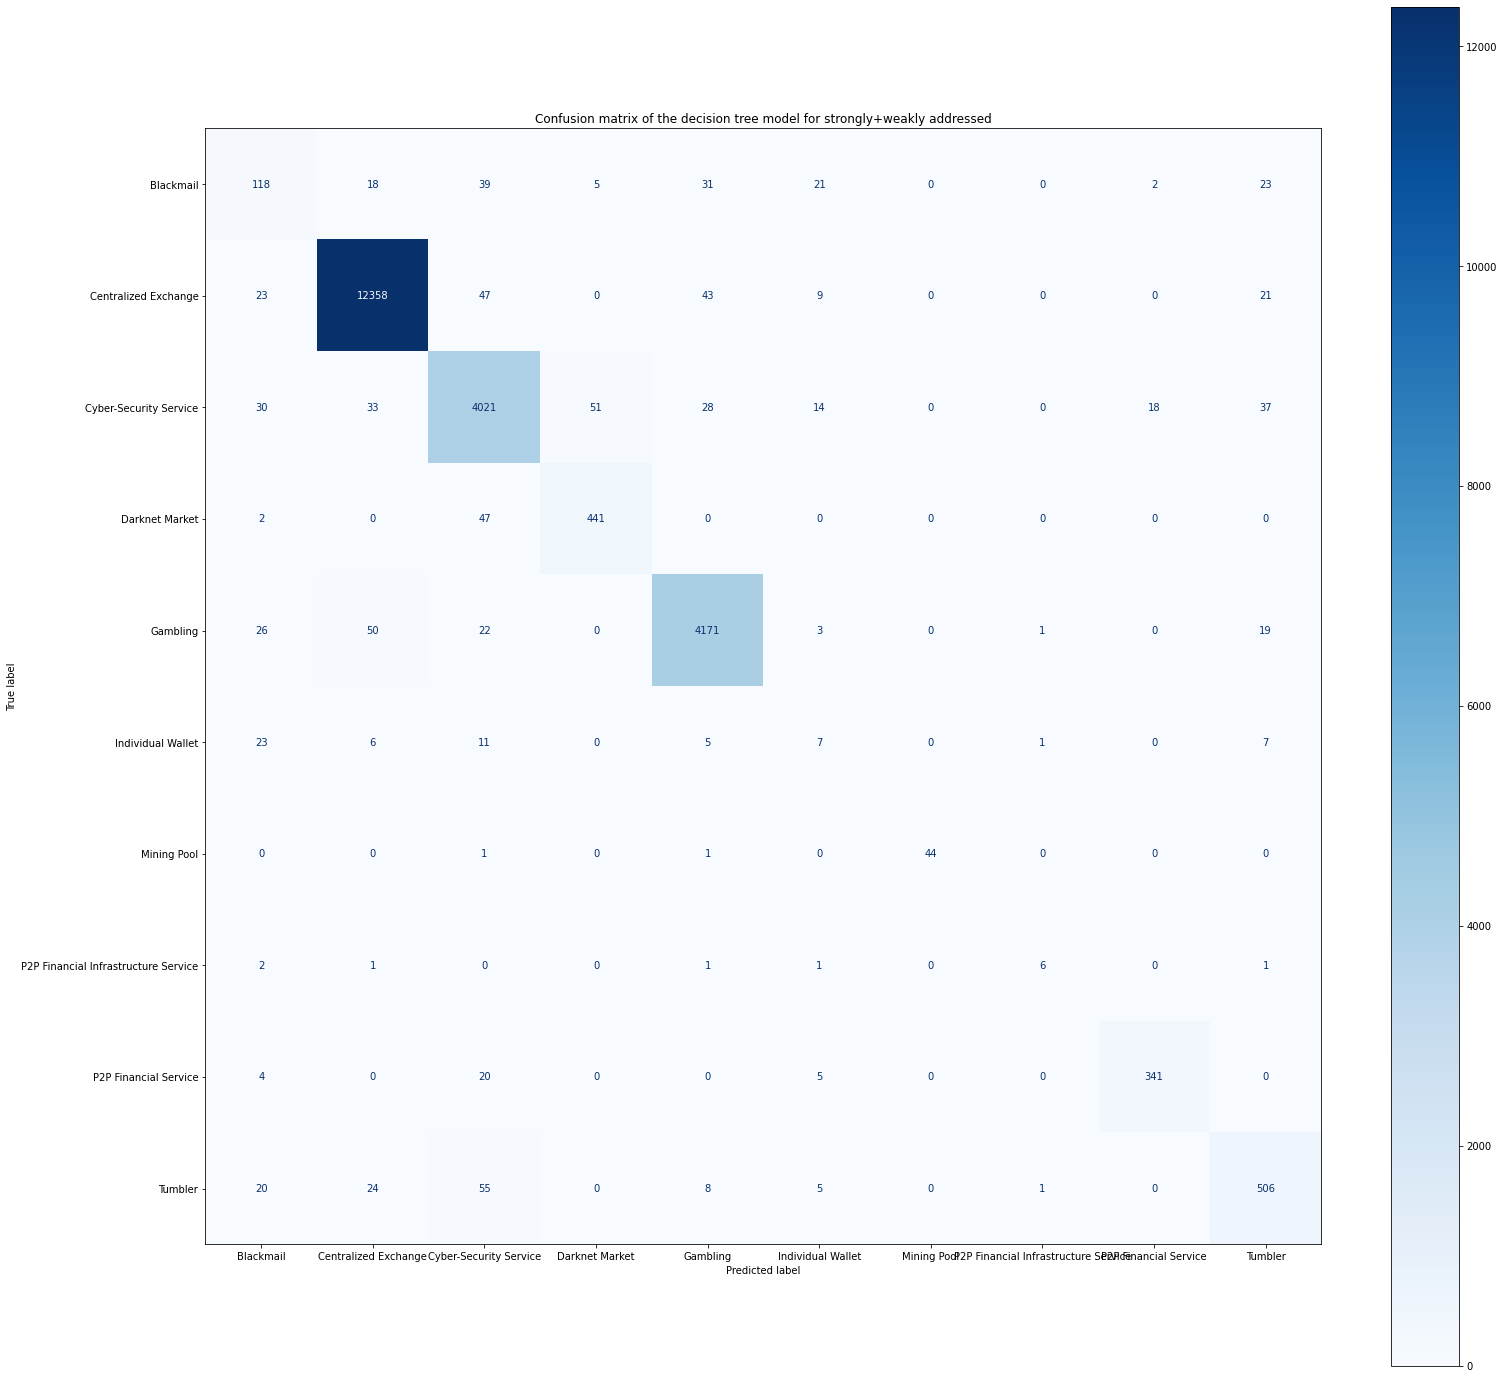

In [270]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the decision tree model for strongly+weakly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using Random Forest classifier

In [271]:
dlf = RandomForestClassifier(random_state=None)
cross_val_score(dlf, train_features, train_labels, cv=8)

array([0.97249417, 0.97086247, 0.97365967, 0.97179487, 0.96876457,
       0.97108883, 0.97388669, 0.9722546 ])

In [272]:
dlf.fit(train_features, train_labels)
predicted_labels_forest = dlf.predict(test_features)

In [273]:
accuracy_score(test_labels, predicted_labels_forest)

0.9736439529699724

In [274]:
f1_score(test_labels, predicted_labels_forest, average=None)

array([0.64344262, 0.99300588, 0.9591623 , 0.88482239, 0.98396468,
       0.05797101, 0.97777778, 0.73684211, 0.95145631, 0.87377049])

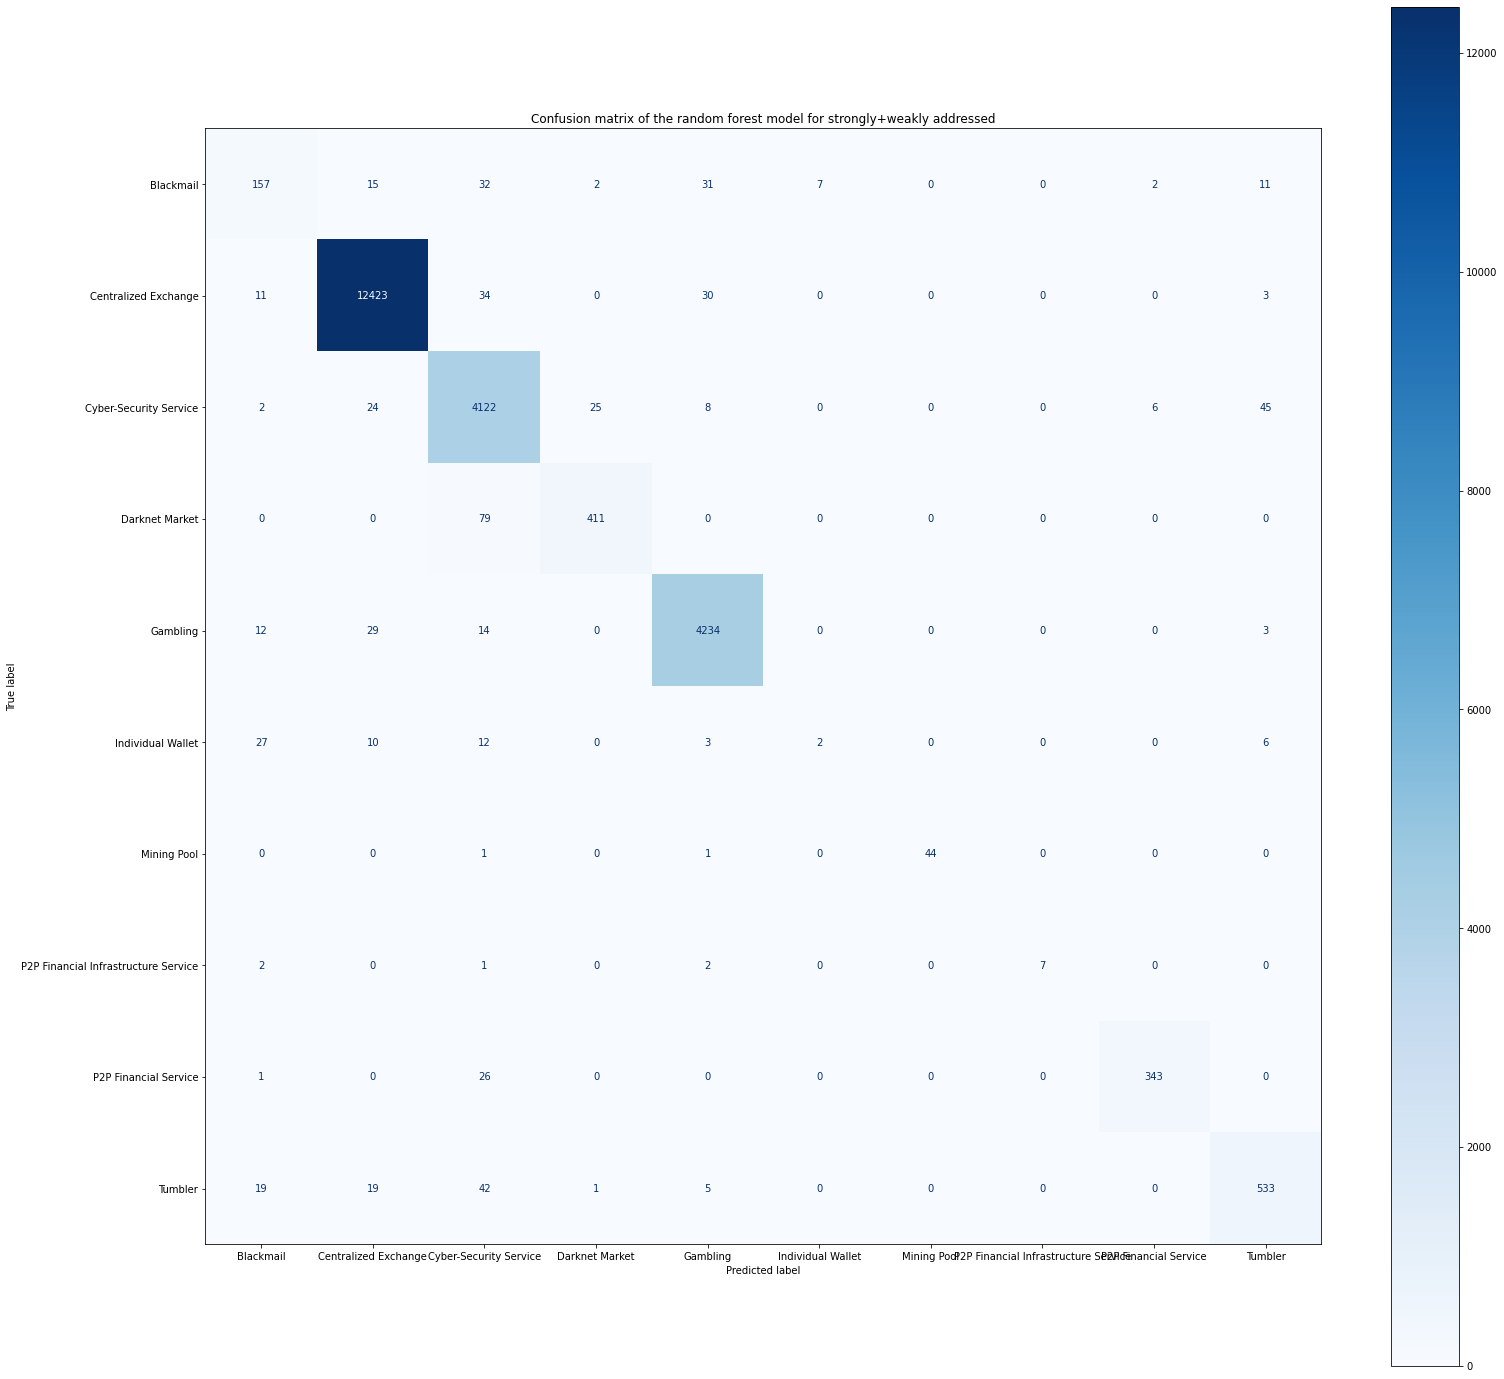

In [275]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the random forest model for strongly+weakly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    dlf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

### On strongly labeled data

#### Using decision tree classifier

In [220]:
train_test_data_strong = pan.read_csv('prepared_features_strong.csv')

In [221]:
train_test_strong_features = train_test_data_strong.drop(['address', 'label'], axis=1)
train_test_strong_labels = train_test_data_strong['label']

In [222]:
train_strong_features, test_strong_features, train_strong_labels, test_strong_labels = train_test_split(train_test_strong_features, 
            train_test_strong_labels, train_size=0.6, random_state=145, stratify=train_test_strong_labels)

In [276]:
clf_strong = DecisionTreeClassifier(random_state=None)
cross_val_score(clf_strong, train_strong_features, train_strong_labels, cv=8)

array([0.96398958, 0.96895735, 0.96445498, 0.96895735, 0.96279621,
       0.96161137, 0.96895735, 0.96563981])

In [277]:
clf_strong.fit(train_strong_features, train_strong_labels)
predicted_strong_labels = clf_strong.predict(test_strong_features)

In [278]:
accuracy_score(test_strong_labels, predicted_strong_labels)

0.9674338013150879

In [279]:
f1_score(test_strong_labels, predicted_strong_labels, average=None)

array([0.98365242, 0.94034091, 0.88362513, 0.97847085, 1.        ,
       0.77777778, 0.91083676, 0.83769634])

In [280]:
recall_score(test_strong_labels, predicted_strong_labels, average=None)

array([0.98432125, 0.93856333, 0.8755102 , 0.97949674, 1.        ,
       0.63636364, 0.8972973 , 0.84805654])

In [281]:
precision_score(test_strong_labels, predicted_strong_labels, average=None)

array([0.9829845 , 0.94212524, 0.89189189, 0.97744711, 1.        ,
       1.        , 0.92479109, 0.82758621])

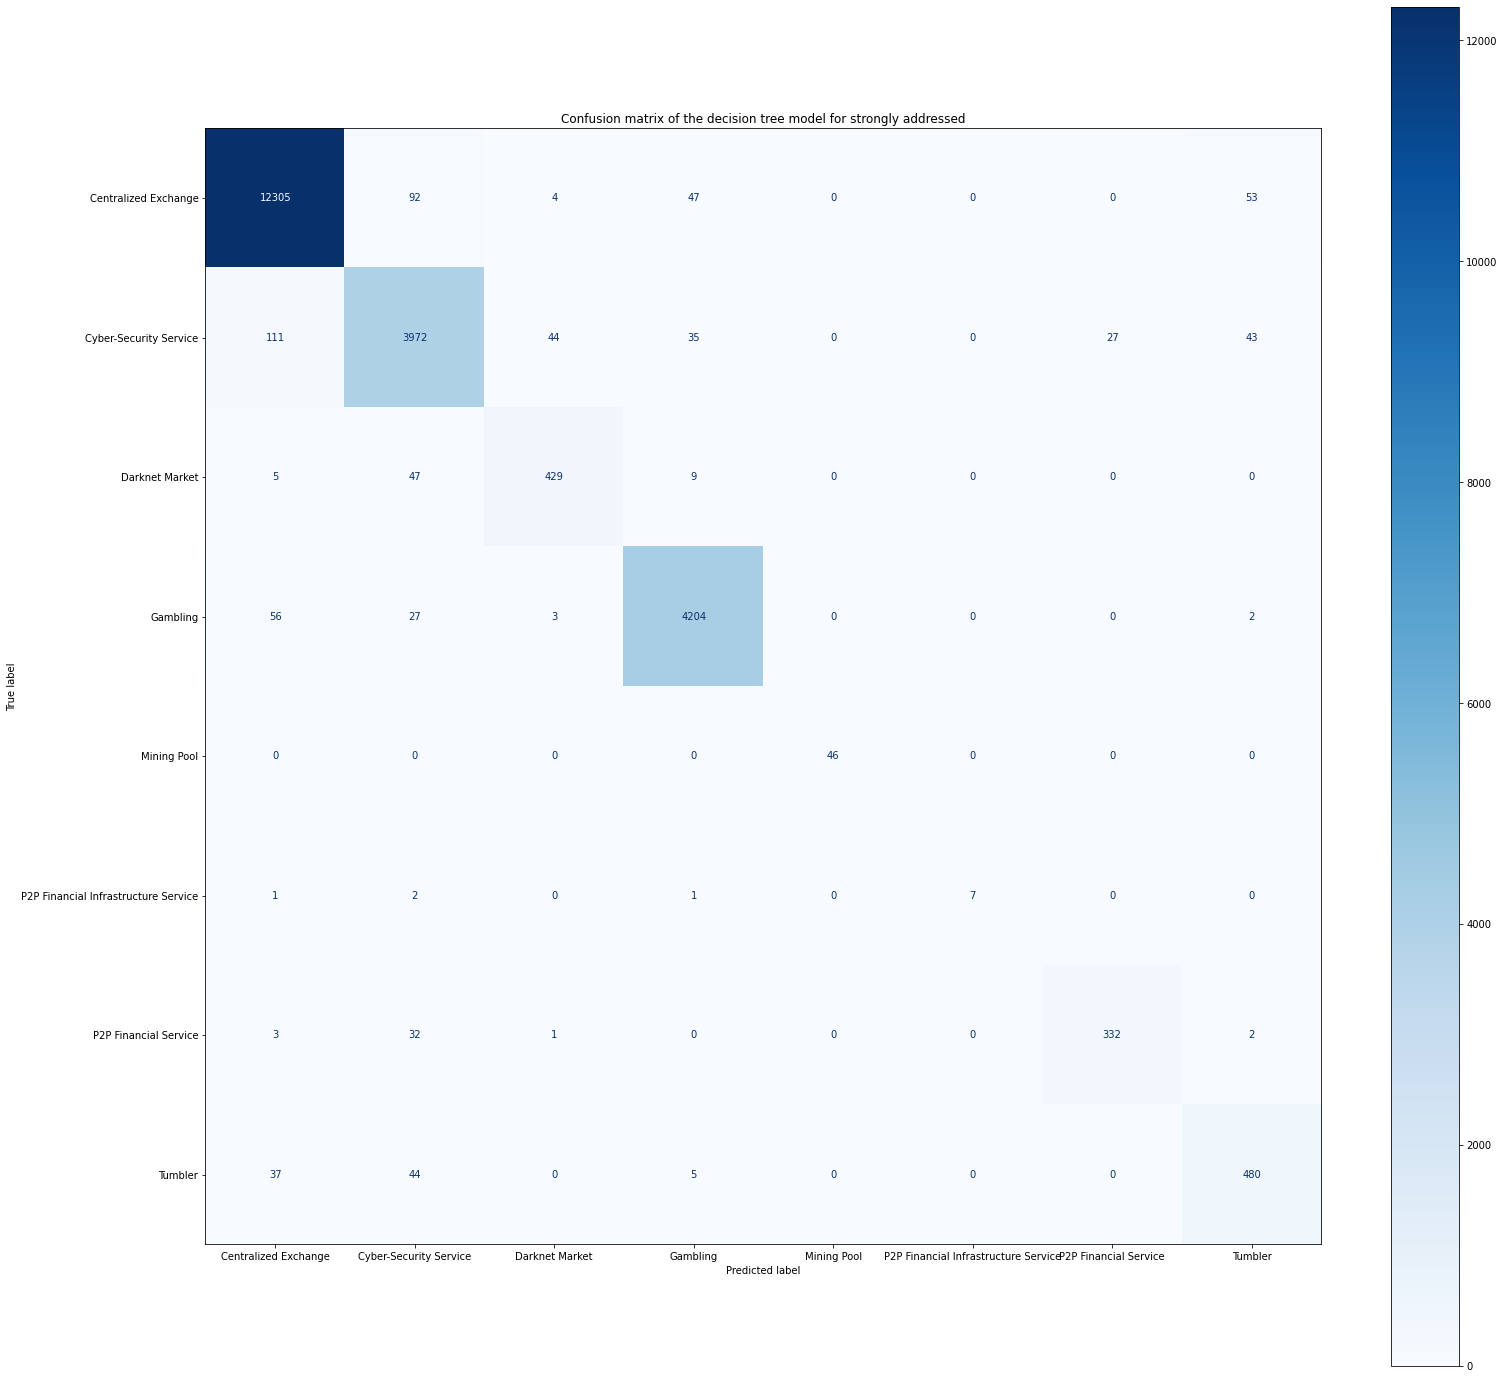

In [282]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the decision tree model for strongly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    clf_strong,
    test_strong_features,
    test_strong_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using random forest classifier

In [283]:
dlf_strong = RandomForestClassifier(random_state=None)
cross_val_score(dlf_strong, train_strong_features, train_strong_labels, cv=8)

array([0.96920161, 0.97251185, 0.97488152, 0.96966825, 0.96777251,
       0.96729858, 0.96848341, 0.97132701])

In [284]:
dlf_strong.fit(train_strong_features, train_strong_labels)
predicted_labels_strong_forest = dlf_strong.predict(test_strong_features)

In [285]:
accuracy_score(test_strong_labels, predicted_labels_strong_forest)

0.9725430957881642

In [286]:
f1_score(test_strong_labels, predicted_labels_strong_forest, average=None)

array([0.9881723 , 0.95055074, 0.83528162, 0.98258736, 1.        ,
       0.625     , 0.93917963, 0.85564304])

In [287]:
recall_score(test_strong_labels, predicted_labels_strong_forest, average=None)

array([0.98912087, 0.9584121 , 0.80204082, 0.97949674, 1.        ,
       0.45454545, 0.8972973 , 0.8639576 ])

In [288]:
precision_score(test_strong_labels, predicted_labels_strong_forest, average=None)

array([0.98722555, 0.94281729, 0.8713969 , 0.98569754, 1.        ,
       1.        , 0.9851632 , 0.847487  ])

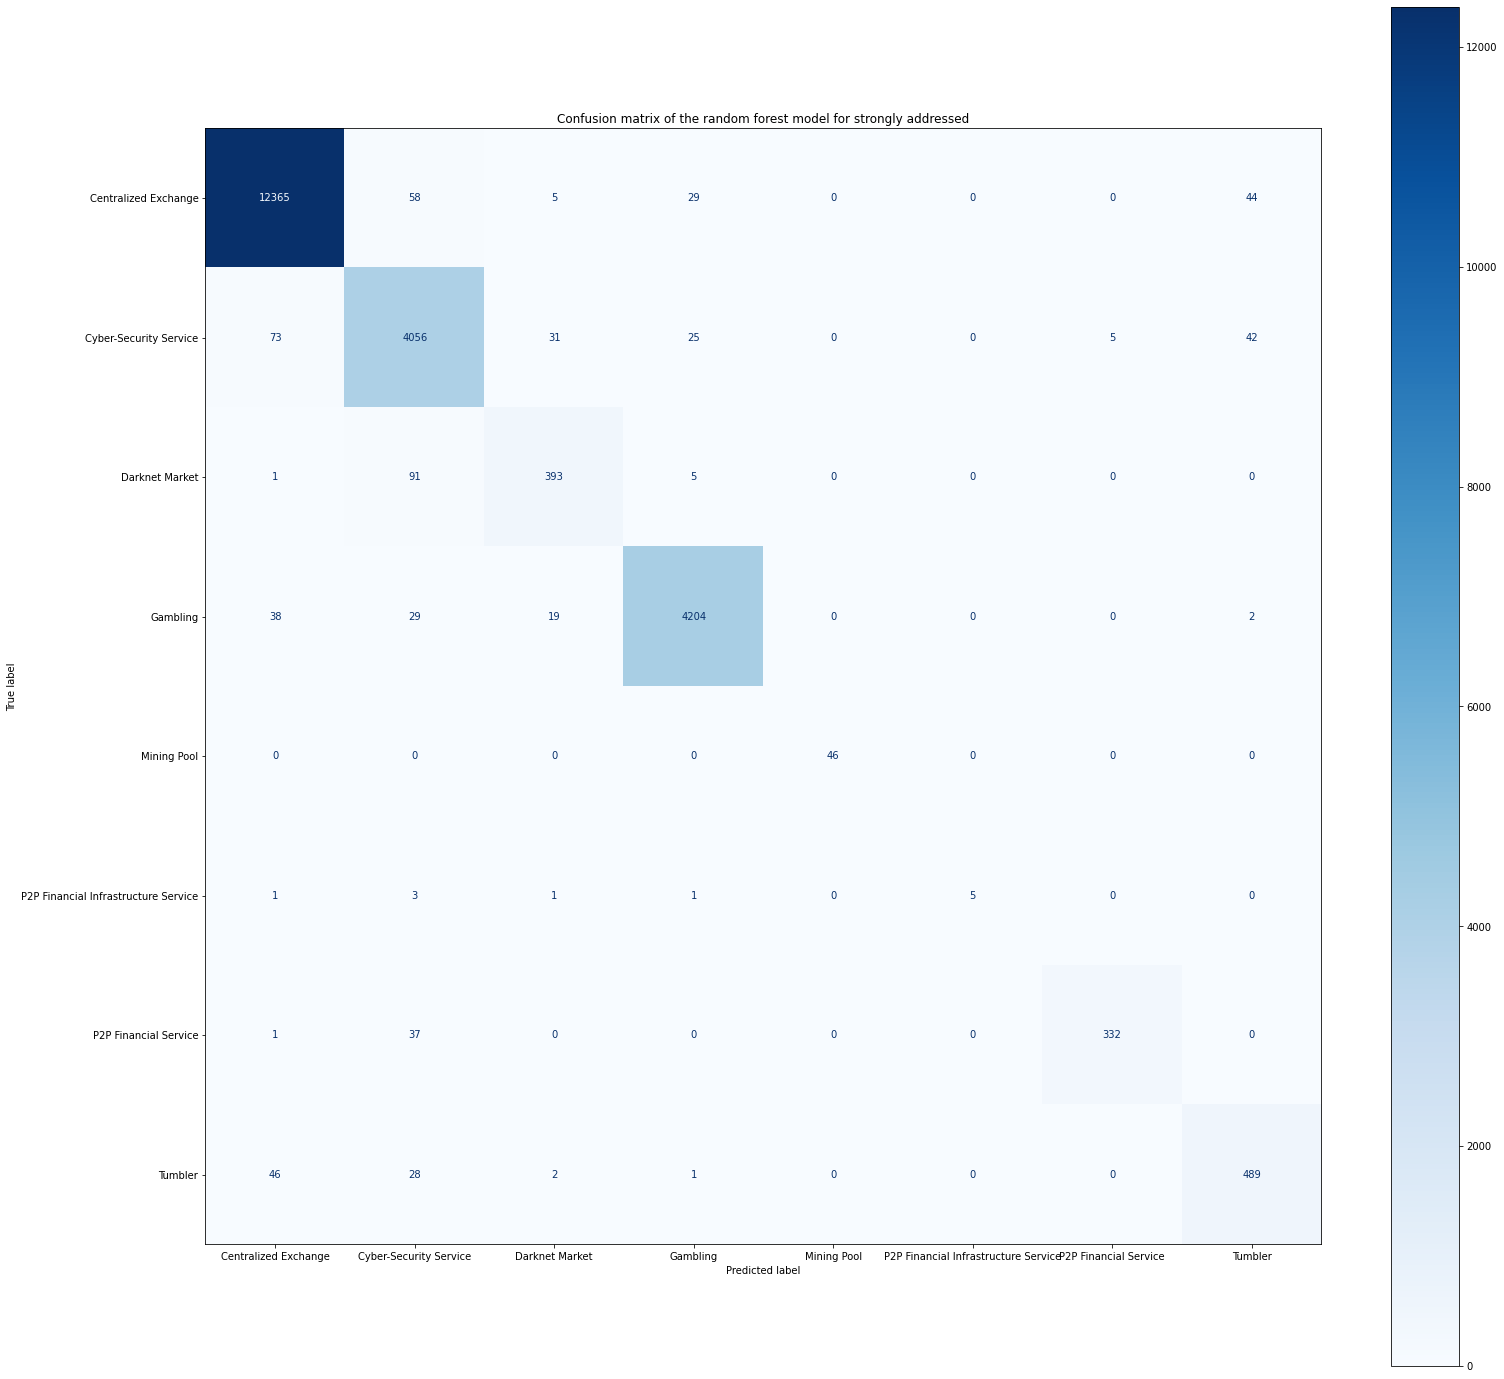

In [289]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the random forest model for strongly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    dlf_strong,
    test_strong_features,
    test_strong_labels,
    cmap=plt.cm.Blues,
    ax=ax
)